# 1.Loading libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [2]:
#Reading Dataset
df = pd.read_csv('../input/nyc-rolling-sales.csv')

In [3]:
# Little peek into the dataset
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [4]:
#Dropping column as it is empty
del df['EASE-MENT']
#Dropping as it looks like an iterator
del df['Unnamed: 0']

del df['SALE DATE']

In [5]:
#Checking for duplicated entries
sum(df.duplicated(df.columns))

1358

In [6]:
#Delete the duplicates and check that it worked
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

# 2.Data Inspection & Visualization

In [7]:
#shape of dataset
df.shape

(83190, 19)

In [8]:
#Description of every column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                           83190 non-null int64
NEIGHBORHOOD                      83190 non-null object
BUILDING CLASS CATEGORY           83190 non-null object
TAX CLASS AT PRESENT              83190 non-null object
BLOCK                             83190 non-null int64
LOT                               83190 non-null int64
BUILDING CLASS AT PRESENT         83190 non-null object
ADDRESS                           83190 non-null object
APARTMENT NUMBER                  83190 non-null object
ZIP CODE                          83190 non-null int64
RESIDENTIAL UNITS                 83190 non-null int64
COMMERCIAL UNITS                  83190 non-null int64
TOTAL UNITS                       83190 non-null int64
LAND SQUARE FEET                  83190 non-null object
GROSS SQUARE FEET                 83190 non-null object
YEAR BUILT                        83190 non-null int64
TAX

In [9]:
#Let's convert some of the columns to appropriate datatype

df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
#df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [10]:
#checking missing values

df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [11]:
miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [12]:
miss=miss.to_frame()
miss.columns=['count']
miss.index.names=['Name']
miss['Name']=miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


<module 'seaborn' from '/opt/conda/lib/python3.6/site-packages/seaborn/__init__.py'>

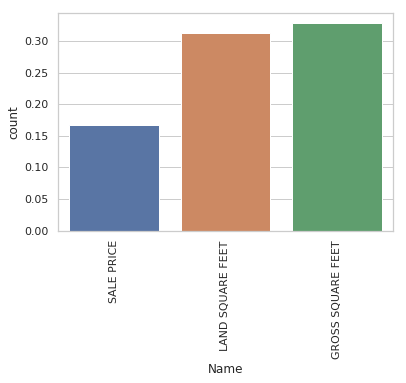

In [13]:
#plot the missing values
sns.set(style='whitegrid',color_codes=True)
sns.barplot(x='Name', y='count',data=miss)
plt.xticks(rotation=90)
sns

There are many missing values in the columns : 
* LAND SQUARE FEET
* GROSS SQUARE FEET
* SALE PRICE

We can drop the rows with missing values or we can fill them up with their mean, median or any other relation.

For time being, let's fill these up with mean values.<br>
Further, We will try to predict the value of SALE PRICE as test data.

In [14]:
# For time being, let's fill these up with mean values.
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [15]:
# Splitting dataset 
test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [16]:
test = test.drop(columns='SALE PRICE')

In [17]:
# Print first 5 rows of test
print(test.shape)
test.head()

(13909, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.0,1900,2,C4
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.0,1900,2,C7
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.0,1920,2,D5


In [18]:
#Printing first rows of our data
print(data.shape)
data.head(10)

(69281, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.00000,6440.000000,1900,2,C2,6625000.0
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.00000,6794.000000,1913,2,C4,3936272.0
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.00000,4615.000000,1900,2,C2,8000000.0
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,8,0,8,1750.00000,4226.000000,1920,2,C4,3192840.0
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,24,0,24,4489.00000,18523.000000,1920,2,D9,16232000.0
11,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2B,400,21,D1,530-532 EAST 5TH STREET,,10009,10,0,10,3717.00000,12350.000000,2009,2,D1,10350000.0
12,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,1.0
13,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,499000.0
14,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 3A",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,10.0
15,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3RD STREET, 5A",,10009,0,0,0,3858.41804,3891.878472,1920,2,C6,529500.0


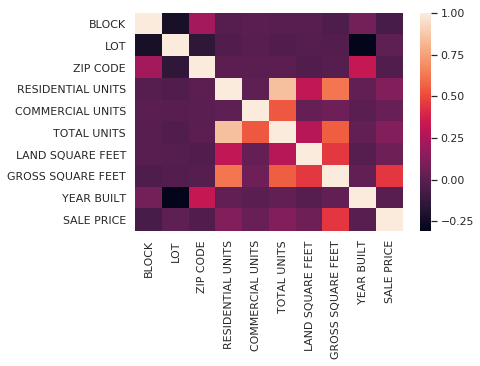

In [19]:
#correlation between the features
corr = data.corr()
sns.heatmap(corr)

Last row represents the correlation of different features with SALE PRICE

In [20]:
#numeric correlation
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449913
TOTAL UNITS          0.126654
RESIDENTIAL UNITS    0.122566
LAND SQUARE FEET     0.060143
COMMERCIAL UNITS     0.044535
LOT                  0.012266
YEAR BUILT          -0.003779
ZIP CODE            -0.034110
BLOCK               -0.061357
Name: SALE PRICE, dtype: float64

In [21]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,6.928100e+04,6.928100e+04,69281.000000,6.928100e+04
mean,4200.305437,374.983473,10739.919458,1.870859,0.164244,2.055109,3.643061e+03,3.640300e+03,1800.113451,1.286521e+06
std,3434.828427,656.820333,1265.389144,14.317577,9.018311,17.026435,3.322172e+04,2.427118e+04,519.752668,1.145690e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1349.000000,21.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.350000e+05
50%,3377.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.970000e+03,2.400000e+03,1938.000000,5.350000e+05
75%,6192.000000,879.000000,11249.000000,2.000000,0.000000,2.000000,3.858418e+03,3.891878e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09



**SALE PRICE**

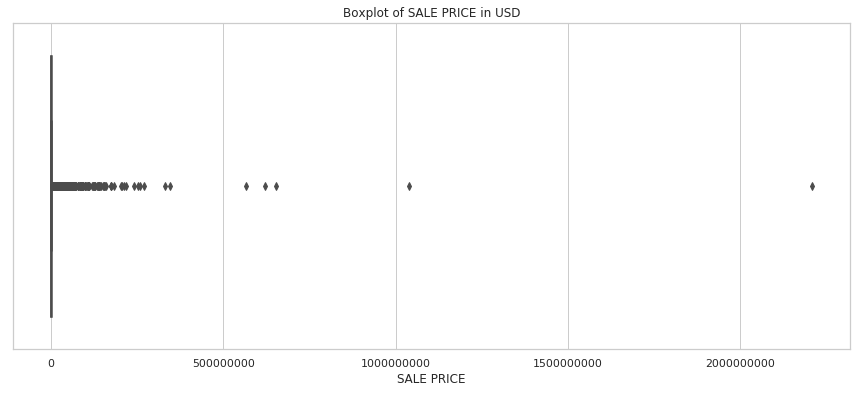

In [22]:
plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

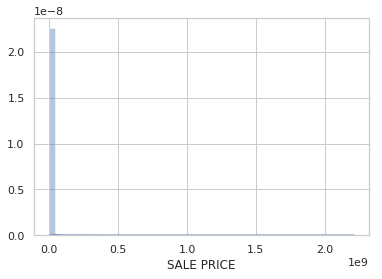

In [23]:
sns.distplot(data['SALE PRICE'])

In [24]:
# Remove observations that fall outside those caps
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

Let's Check Again

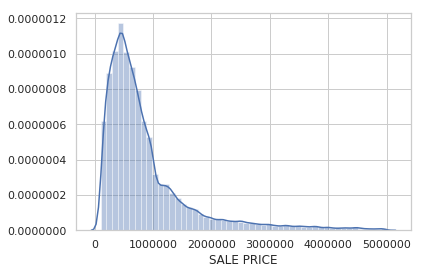

In [25]:
sns.distplot(data['SALE PRICE'])

In [26]:
#skewness of SalePrice
data['SALE PRICE'].skew()

2.3437455096169386

SALE PRICE is highly right skewed. So, we will log transform it so that it give better results.

0.19896303705046872


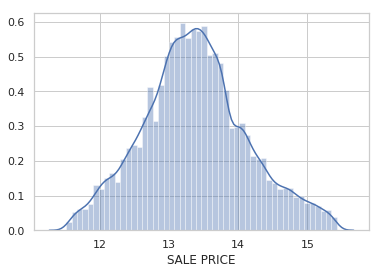

In [27]:
sales=np.log(data['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

Well now we can see the symmetry and thus it is normalised.

**Let's Visualize Numerical data**

**SQUARE FEET**

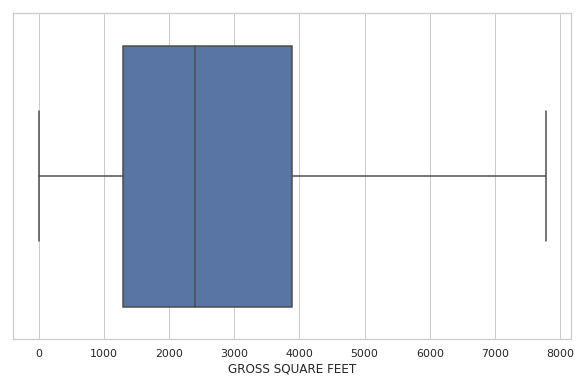

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(x='GROSS SQUARE FEET', data=data,showfliers=False)

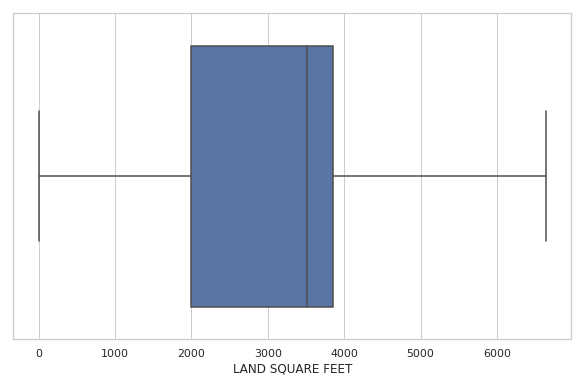

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(x='LAND SQUARE FEET', data=data,showfliers=False)

In [30]:
data = data[data['GROSS SQUARE FEET'] < 10000]
data = data[data['LAND SQUARE FEET'] < 10000]

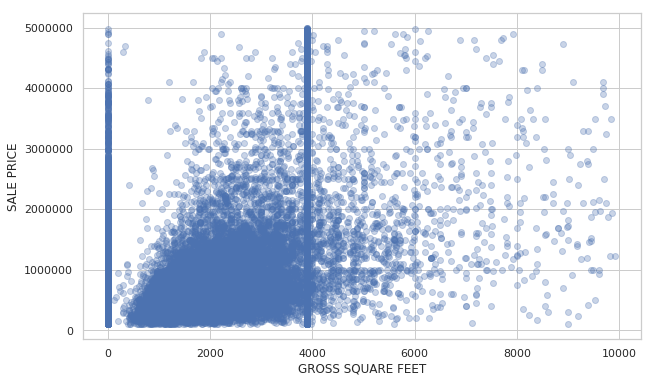

In [31]:
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})

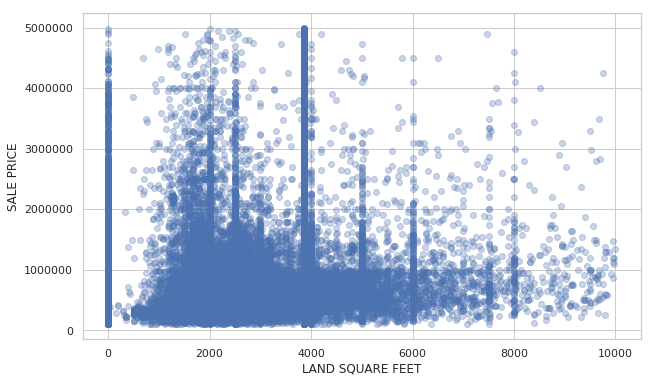

In [32]:
plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})

**Total Units, Commercial Units, Residential Units**

In [33]:
data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,24570
0,0,15489
2,2,9473
3,3,2720
4,4,695
6,6,360
5,5,170
8,8,133
7,7,70
9,9,56


Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units

In [34]:
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] != 2261)] 

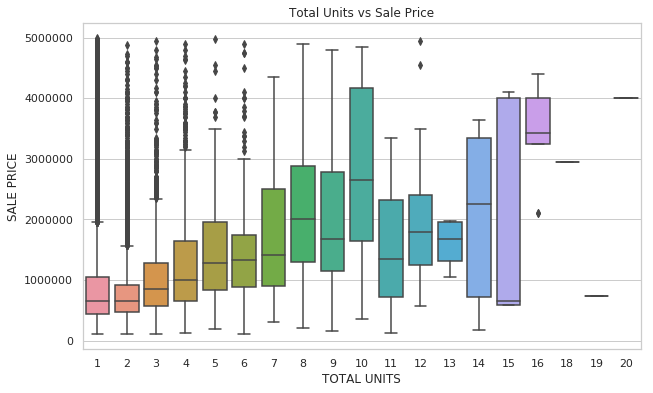

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=data)
plt.title('Total Units vs Sale Price')
plt.show()

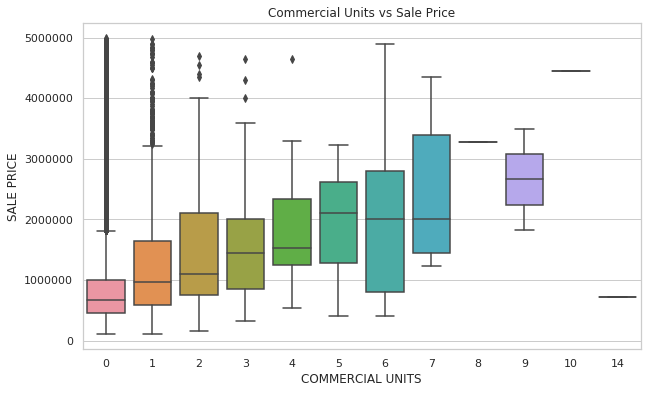

In [36]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=data)
plt.title('Commercial Units vs Sale Price')
plt.show()

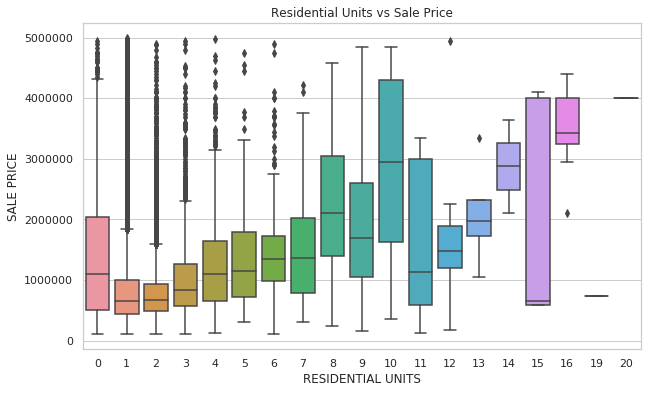

In [37]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=data)
plt.title('Residential Units vs Sale Price')
plt.show()

**Let's Visualize categorical data**

In [38]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,38342,38342,38342,38342,38342,38342,38342,38342,38342
unique,5,247,36,9,104,30426,2642,3,104
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,R4,131-05 40TH ROAD,,1,R4
freq,12599,1674,12215,23977,8918,209,26395,25206,8922


**TAX CLASS AT PRESENT**

In [39]:
# Starting with TAX CLASS AT PRESENT
data['TAX CLASS AT PRESENT'].unique()

[2B, 2, 2A, 2C, 4, 1C, 1, 1A, 1B]
Categories (9, object): [2B, 2, 2A, 2C, ..., 1C, 1, 1A, 1B]

In [40]:
pivot=data.pivot_table(index='TAX CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT PRESENT,
1,594000.0
1A,390000.0
1B,640606.5
1C,958668.0
2,980000.0
2A,1200000.0
2B,1847500.0
2C,835000.0
4,1050000.0


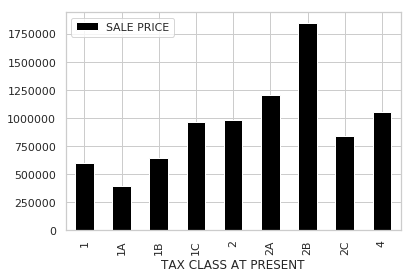

In [41]:
pivot.plot(kind='bar', color='black')

**TAX CLASS AT TIME OF SALE**

In [42]:
#  TAX CLASS AT TIME OF SALE
data['TAX CLASS AT TIME OF SALE'].unique()

[2, 4, 1]
Categories (3, int64): [2, 4, 1]

In [43]:
pivot=data.pivot_table(index='TAX CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,582487.5
2,990000.0
4,1050000.0


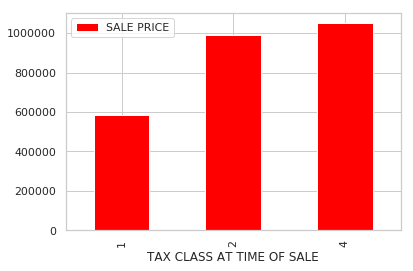

In [44]:
pivot.plot(kind='bar', color='red')

**BOROUGH**

In [45]:
# BOROUGH
data['BOROUGH'].unique()

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [46]:
pivot=data.pivot_table(index='BOROUGH', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
BOROUGH,
1,1435000.0
2,452750.0
3,860000.0
4,635000.0
5,470000.0


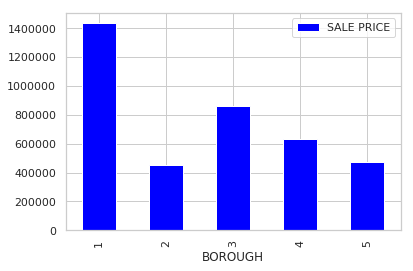

In [47]:
pivot.plot(kind='bar', color='blue')

***It means max sale price is of BOROUGH==1 that is Manhattan.***

**BUILDING CLASS CATEGORY**

In [48]:
# BUILDING CLASS CATEGORY
print(data['BUILDING CLASS CATEGORY'].nunique())

pivot=data.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot

36


,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,510000.0
02 TWO FAMILY DWELLINGS,664075.5
03 THREE FAMILY DWELLINGS,820000.0
04 TAX CLASS 1 CONDOS,420405.0
05 TAX CLASS 1 VACANT LAND,720000.0
06 TAX CLASS 1 - OTHER,500000.0
07 RENTALS - WALKUP APARTMENTS,1280000.0
08 RENTALS - ELEVATOR APARTMENTS,3670000.0
11A CONDO-RENTALS,999000.0


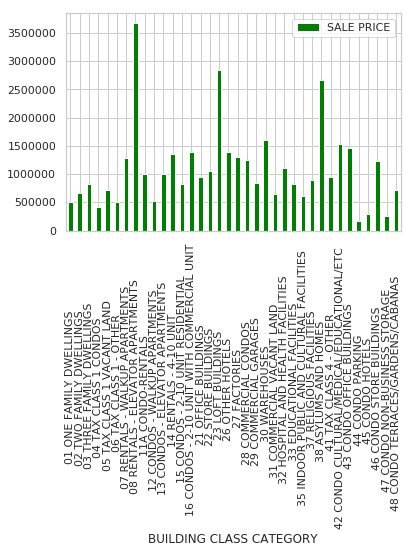

In [49]:
pivot.plot(kind='bar', color='Green')

# 3. Data Pre Processing

**Let's see our dataset again**

In [50]:
del data['ADDRESS']
del data['APARTMENT NUMBER']

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 17 columns):
BOROUGH                           38342 non-null category
NEIGHBORHOOD                      38342 non-null object
BUILDING CLASS CATEGORY           38342 non-null object
TAX CLASS AT PRESENT              38342 non-null category
BLOCK                             38342 non-null int64
LOT                               38342 non-null int64
BUILDING CLASS AT PRESENT         38342 non-null object
ZIP CODE                          38342 non-null int64
RESIDENTIAL UNITS                 38342 non-null int64
COMMERCIAL UNITS                  38342 non-null int64
TOTAL UNITS                       38342 non-null int64
LAND SQUARE FEET                  38342 non-null float64
GROSS SQUARE FEET                 38342 non-null float64
YEAR BUILT                        38342 non-null int64
TAX CLASS AT TIME OF SALE         38342 non-null category
BUILDING CLASS AT TIME OF SALE    38342 non-null o

**Normalising and Transforming Numerical columns**

In [52]:
numeric_data.columns

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE'],
      dtype='object')

In [53]:
#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])

In [54]:

scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]

In [55]:
data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.552838,-0.871424,C4,-1.442057,4.726583,-0.204406,4.897089,-0.332369,3.247655,0.176451,2,C4,2.478171
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.545023,-0.654228,C4,-1.442057,4.109626,-0.204406,4.245205,-0.669316,1.421318,0.191071,2,C4,2.174164
76,1,ALPHABET CITY,12 CONDOS - WALKUP APARTMENTS,2,-1.584890,1.174680,R2,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,-3.818937,2,R2,-0.206132
79,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.611925,1.175214,R4,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,0.191071,2,R4,0.094653
80,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.611925,1.175747,R4,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,0.191071,2,R4,0.113914


In [56]:
#Dropping few columns
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']

**One hot encoding categorical columns**

In [57]:
#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']


In [58]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 56 columns):
BOROUGH_1                                                               38342 non-null uint8
BOROUGH_2                                                               38342 non-null uint8
BOROUGH_3                                                               38342 non-null uint8
BOROUGH_4                                                               38342 non-null uint8
BOROUGH_5                                                               38342 non-null uint8
BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                         38342 non-null uint8
BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                         38342 non-null uint8
BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                       38342 non-null uint8
BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS                           38342 non-null uint8
BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND    

In [59]:
# Replacing categorical columns with dummies
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [60]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 66 columns):
BLOCK                                                                   38342 non-null float64
LOT                                                                     38342 non-null float64
ZIP CODE                                                                38342 non-null float64
RESIDENTIAL UNITS                                                       38342 non-null float64
COMMERCIAL UNITS                                                        38342 non-null float64
TOTAL UNITS                                                             38342 non-null float64
LAND SQUARE FEET                                                        38342 non-null float64
GROSS SQUARE FEET                                                       38342 non-null float64
YEAR BUILT                                                              38342 non-null float64
SALE PRICE                          

## Train/Test Split

In [61]:
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((38342, 65), (38342,))

In [62]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.3 , random_state =34)

In [63]:
# Training set
X_train.shape , Y_train.shape

((26839, 65), (26839,))

In [64]:
#Testing set
X_test.shape , Y_test.shape

((11503, 65), (11503,))

# 4. Modelling

In [65]:
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

### 4.1 Linear Regression

In [66]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test,Y_pred_lin)

0.7535412926078288

### 4.2. Lasso Regression

In [67]:
alpha=0.00099
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)

0.7545342173339241

### 4.3. Ridge Regression

In [68]:
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test,Y_pred_ridge)

0.7536328245407319

### 4.4. RandomForest Regressor

In [69]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.5861966612369766

# 5. Conclusion

**We can see that Random Forest Regressor works best for this dataset with RSME score of 0.588**

**Please UPVOTE if found useful !**